# Libraries and modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import os
import pickle
import utils

from tqdm import tqdm
from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from PyAstronomy import pyasl
from spectres import spectres
from num2tex import num2tex

# Display configs

In [2]:
#####################
# Display and backend
#####################
plt.style.use("default") # Reset to default before layering on any changes
FIG_LARGE = (12, 8) # Default plot figure size for large figures
%config InlineBackend.figure_format = "retina" # Crisp retina display on macs
#%matplotlib qt5 

################
# Theme settings
################
notebook_mode = "paper" # (paper | dark)
sns.set(palette="colorblind", color_codes=True, context="talk")

if notebook_mode.lower() == "paper":
    tick_params = {
        "xtick.top":True,
        "xtick.direction":"in",
        "ytick.right":True,
        "ytick.direction":"in",
        "axes.spine.right":True
    }
    sns.set_style("ticks", tick_params)
    params = {
        "axes.formatter.limits":(-3, 7),
        "xtick.major.size":14,
        "ytick.major.size":14,
        "xtick.minor.visible":True,
        "ytick.minor.visible":True,
    }
    plt.rcParams.update(params)

elif notebook_mode.lower() == "dark":
    plt.style.use("cyberpunk")

else:
    plt.style.use("default")

# Motivation

We want to determine the feasibility of detecting $\text O_2$ in Earth-like exoplanets. This has been done for theoretical planets around M-dwarfs [here](https://arxiv.org/pdf/1905.05862.pdf), and now we would like to extend the analysis to planets around G and K type stars. To accomplish this, we will start by reproducing Fig. 4 in this paper (how many transits would you need on a world class ELT to positively detect oxygen on an Earth-analog exoplanet?). The plan of attack is the following:

1. Generate model observed spectra $C$ (Eq. 3) using the following input models:
    - $S$: stellar spectra (PHOENIX)
    - $T$: tellurics (Kurucz)
    - $P$: Earth-like transmission spectrum model (HITRAN)
    - $\sigma_{r/w}$: observational noise (e.g. red/white noise)
1. Estimate oxygen detection significance
1. Experiment with different oxygen band combinations
1. Experiment with different red and white noise

<br>

Note: The final working data will be stored in a dictionary of numpy arrays, structured in the following way:
```
data_resampled
├── 1e5
├── 1e6
├── 3e5 (Resolution)
│   ├── S
│   ├── T
│   ├── P (Spectrum type)
│   │   ├── flux
│   │   └── flux_shifted (Doppler shifted normalized flux)
│   │       └── *ndarray
│   └── wav (Rest frame wavelength array, in cm) 
│       └── *ndarray
├── 5e5
└── wav_band (Lower and upper wavelength, in cm)
    └── *ndarray
```

Only a few representative branches are shown for clarity.

# 1) Generate model observed spectra
The model spectra $C$ is given by,

\begin{gather}
a = (1 + v_\star c^{-1})S + \left[1 + (v_\star + v_\text{pl}) c^{-1}\right]\epsilon^{-1}P
\quad, \\
\tilde C = a\left(1+ \epsilon^{-1}\right)^{-1} T \quad, \\
C = \tilde C \times G \quad.
\end{gather}

This requires the three externally computed transmission models (S, T, and P), which we collect below.

## Load raw data

In [3]:
# For: Star
# Source: http://phoenix.astro.physik.uni-goettingen.de/?page_id=15
# Units: wav (Å), flux (erg/s/cm^2/cm)
# Filename structure: 
#     lte<T_eff>-<logg>-<[Fe/H]>...-HiRes.fits
#
# Note: according to http://phoenix.astro.physik.uni-goettingen.de/?page_id=10
# there is typo in header. Mass should be in grams and luminosity in erg/s
dirpath = "./data/PHOENIX"
fpath = f"{dirpath}/lte03600-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"
header_star, flux_star = utils.read_fits(fpath)
fpath = f"{dirpath}/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits"
header_star_wav, wav_star = utils.read_fits(fpath)

# For: Tellurics
# Source: 
#    http://etimecalprev.hq.eso.org/observing/etc/data/SM-01_5000_old/SM-01_5000/sm-01_mod2/data/lib/
# Units: wav (um), flux (normalized)
# Filename structure:
#     pwv_R<resolution>k_airmass<airmass>/LBL_A<airmass>0_s0_w<pwv>_R0<resolution>_<spectype>
#
# Note: abbreviations here: http://etimecalprev.hq.eso.org/observing/etc/data/SM-01_5000_old/SM-01_5000/sm-01_mod2/data/libstruct_pwv.dat
dirpath = "./data/Tellurics"
fpath = f"{dirpath}/pwv_R300k_airmass1.0/LBL_A10_s0_w005_R0300000_T.fits"
header_tell, data_tell = utils.read_fits(fpath, ext_idx=1)
wav_tell, flux_tell = data_tell["lam"], data_tell["trans"]

# For: Planet
# Source: Mercedes HITRAN data
# Units: wav (nm), flux (normalized)
# Filename structure: 
#     O2_<resolution>.txt
dirpath = "./data/ExoplanetO2"
fpath = f"{dirpath}/O2_3E5.txt"
names = ["Wavnum", "Wav", "Trans"] # [Wavenumber (cm-1), Wavlength (nm), T]
pd_kwargs = {
    "names":names,
    "sep":" ",
    "skiprows":4,
    "skipinitialspace":True,
}
df = pd.read_csv(fpath, **pd_kwargs)
# Reverse so wavelength increasing like the others
wav_planet, flux_planet = df["Wav"][::-1], df["Trans"][::-1]

# Put spectra in common units (cm)
wav_S = wav_star * 1e-8 # Stellar (Å -> cm)
wav_T = wav_tell * 1e-4 # Telluric (micrometer -> cm)
wav_P = wav_planet.values * 1e-7 # Planet (nm -> cm)

# Rename spectra to S, T, P for convenience
flux_S = flux_star / np.max(flux_star) # Normalize
flux_T = flux_tell
flux_P = flux_planet.values

# Store model data in common cgs system along with some plot configs
data = {
    'S':{"wav":wav_S, "flux":flux_S},
    'T':{"wav":wav_T, "flux":flux_T},
    'P':{"wav":wav_P, "flux":flux_P},
}

## Preview

Now that the data for S, T, and P are in common units and have been loaded into memory in the `data` dict, let's take a look at it:

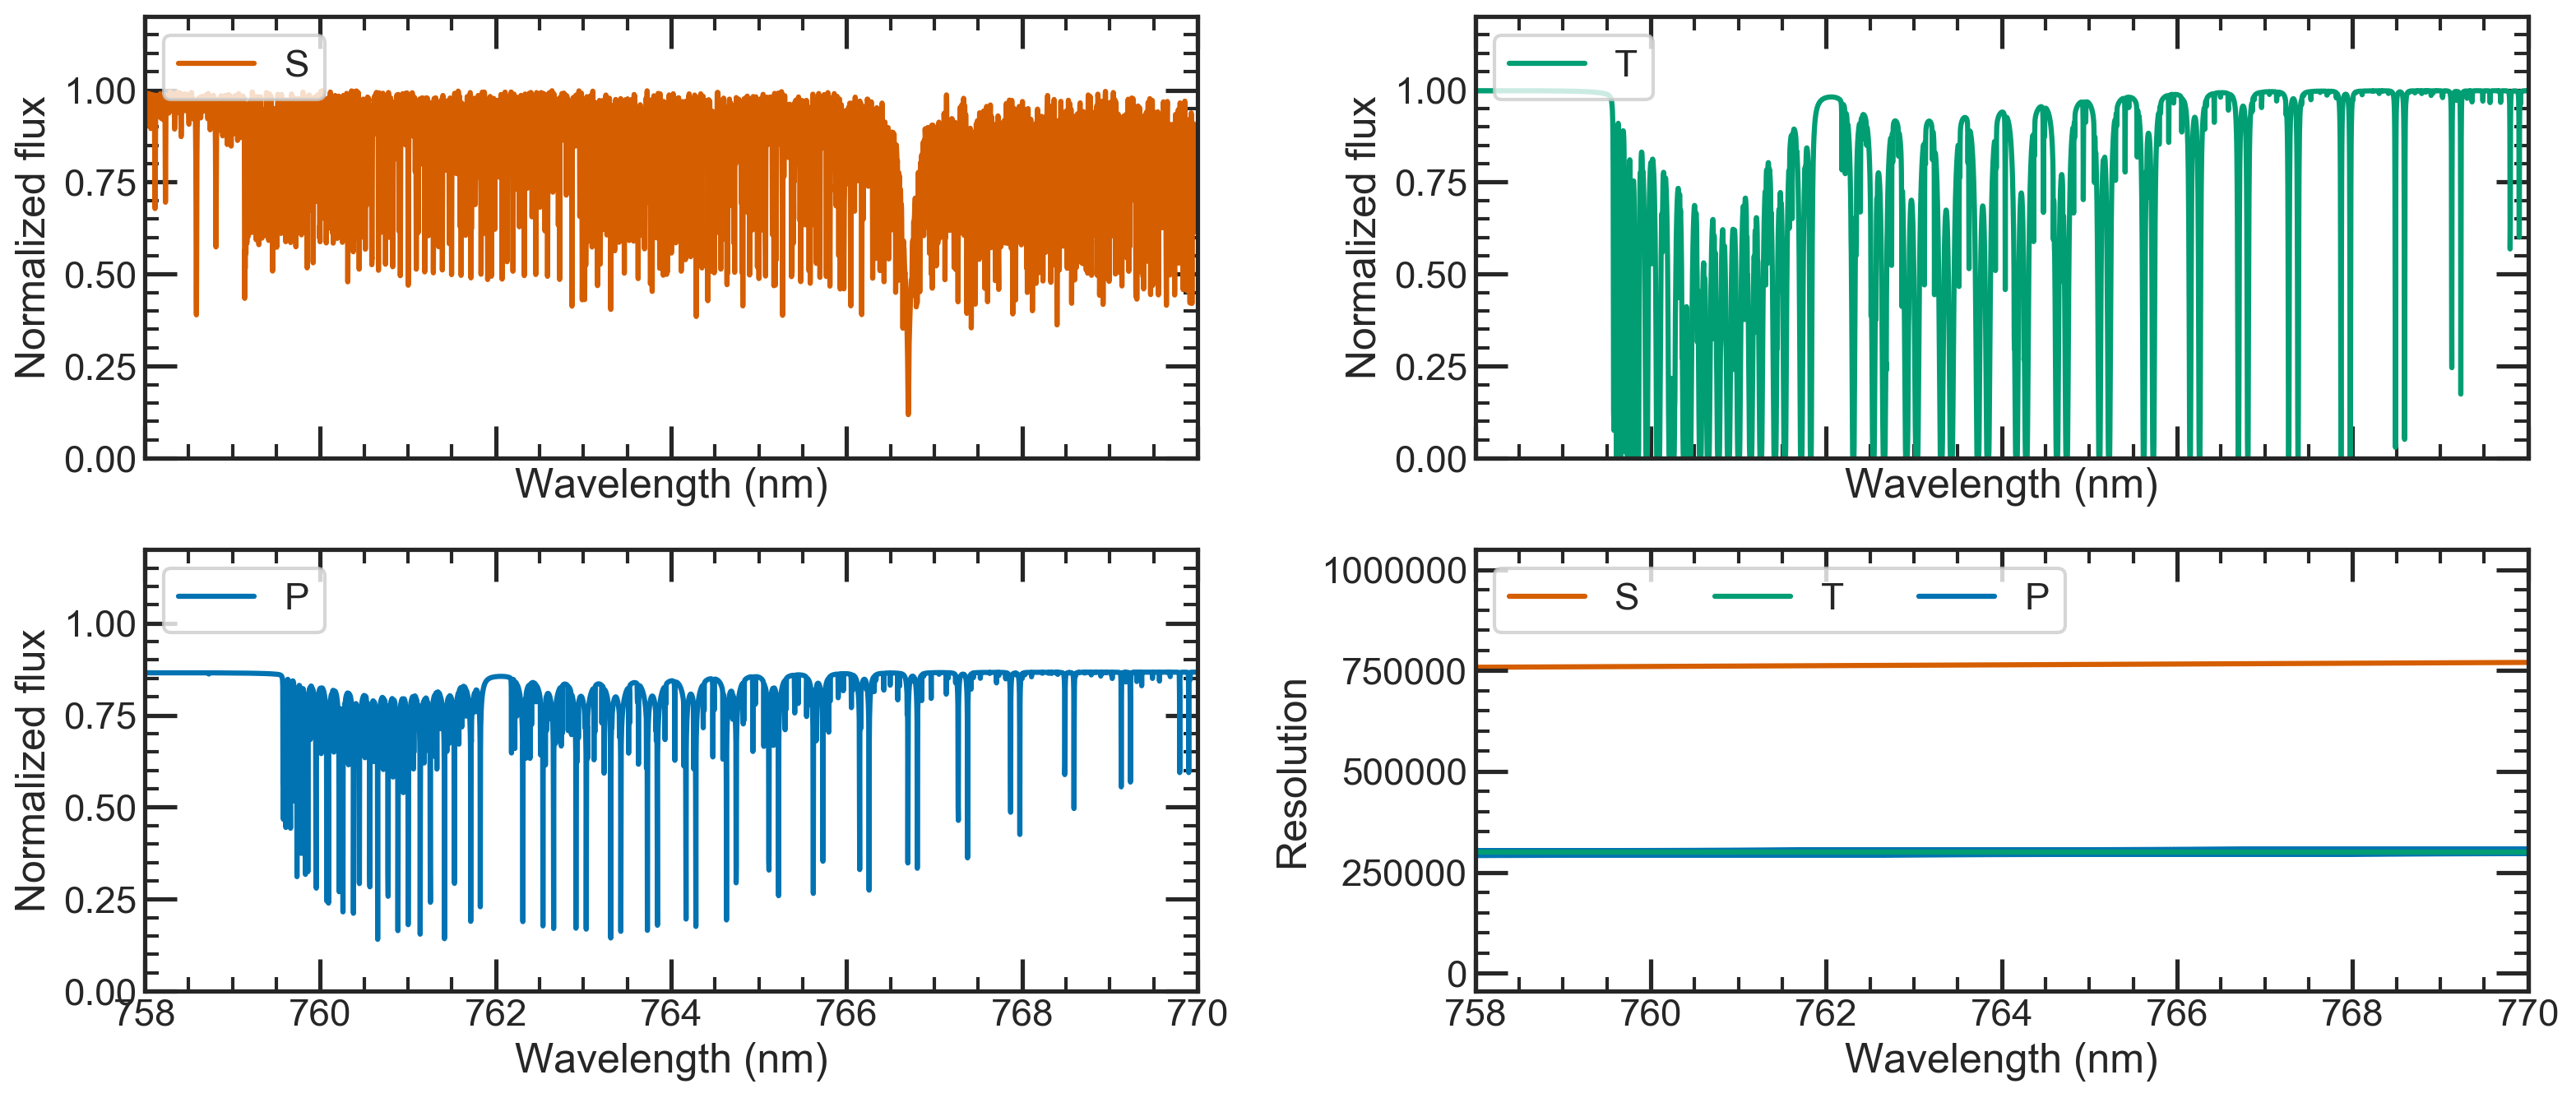

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
ax_STP, ax_res = axes.flatten()[:3], axes.flatten()[-1]

###########
# STP plots
###########
colors = ['r', 'g', 'b']
for ax, d, c in zip(ax_STP, data.items(), colors):
    wav_cm, flux = d[1]["wav"]*1e7, d[1]["flux"]
    ax.plot(wav_cm, flux, color=c, label=d[0])
    # Make some space at the top for the legend
    [ax.set_ylim(0, 1.2) for ax in ax_STP]
    ax.legend(loc=2, ncol=3)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Normalized flux")
    
#################
# Resolution plot
#################
for d, c in zip(data.items(), colors):
    zorder = 1 if d[0] == 'T' else 0 # Keeps T from hiding behind P
    ax_res.plot(
        d[1]["wav"]*1e7, utils.get_R(d[1]["wav"]), 
        color=c, zorder=zorder, label=d[0]
    )
ax_res.yaxis.set_ticks(np.linspace(0, 1e6, 5))
ax_res.legend(loc=2, ncol=3)
ax_res.set_xlabel("Wavelength (nm)")
ax_res.set_ylabel("Resolution")

# Zoom in on a particular wavelength band on all plots
wav_min, wav_max = [758*1e-7, 770*1e-7] # cm
ax_res.set_xlim(wav_min*1e7, wav_max*1e7) # nm

fig.tight_layout()

## Resample

The bottom right panel is a plot of the resolution as a function of wavelength for each model computed in `utils.get_R`. For simplicity, let's get them all on the same wavelength grid with [SpectRes](https://spectres.readthedocs.io/en/latest/). While we are at it, let's also use this package to truncate all of the spectra to `wav_band` = $[\lambda_\text{min} - \lambda_\text{max}]$ to speed up computation later. Note: The resampling process is implemented in `utils.resample`

In [9]:
# Define resolutions to compute in particular wavelength band
wav_band = np.array([759*1e-7, 772*1e-7]) # cm
Rs = ["1e5", "3e5", "5e5", "1e6"]
# Hold resampled wav and flux for each R
data_resampled = {R:{'S':{}, 'T':{}, 'P':{}} for R in Rs}
data_resampled["wav_band"] = wav_band

##########
# Resample
##########
for R in Rs:
    wavs_check = [] # For array comparison later. Should be the same
    for model in ['S', 'T', 'P']:
        wav_resampled, flux_resampled = utils.resample(
            data[model]['wav'],
            wav_band,
            float(R),
            data[model]['flux'],
        )
        wavs_check.append(wav_resampled)
        data_resampled[R][model]["flux"] = flux_resampled

    # Raise an error if resampled wavelengths are not the same for each model
    # Otherwise, save a "master" one to the top level of `data_resampled[R]`
    # for convenience.
    if (
        np.array_equal(wavs_check[0], wavs_check[1])
        and 
        np.array_equal(wavs_check[0], wavs_check[2])
    ):
        # Add top-level key
        data_resampled[R]["wav"] = wavs_check[0]
    else:
        print("Error with wavelength resampling. Re-check input wavelengths.")

Now let's check if the models are all on a common wavelength grid and resolution for $R=3\times10^5$

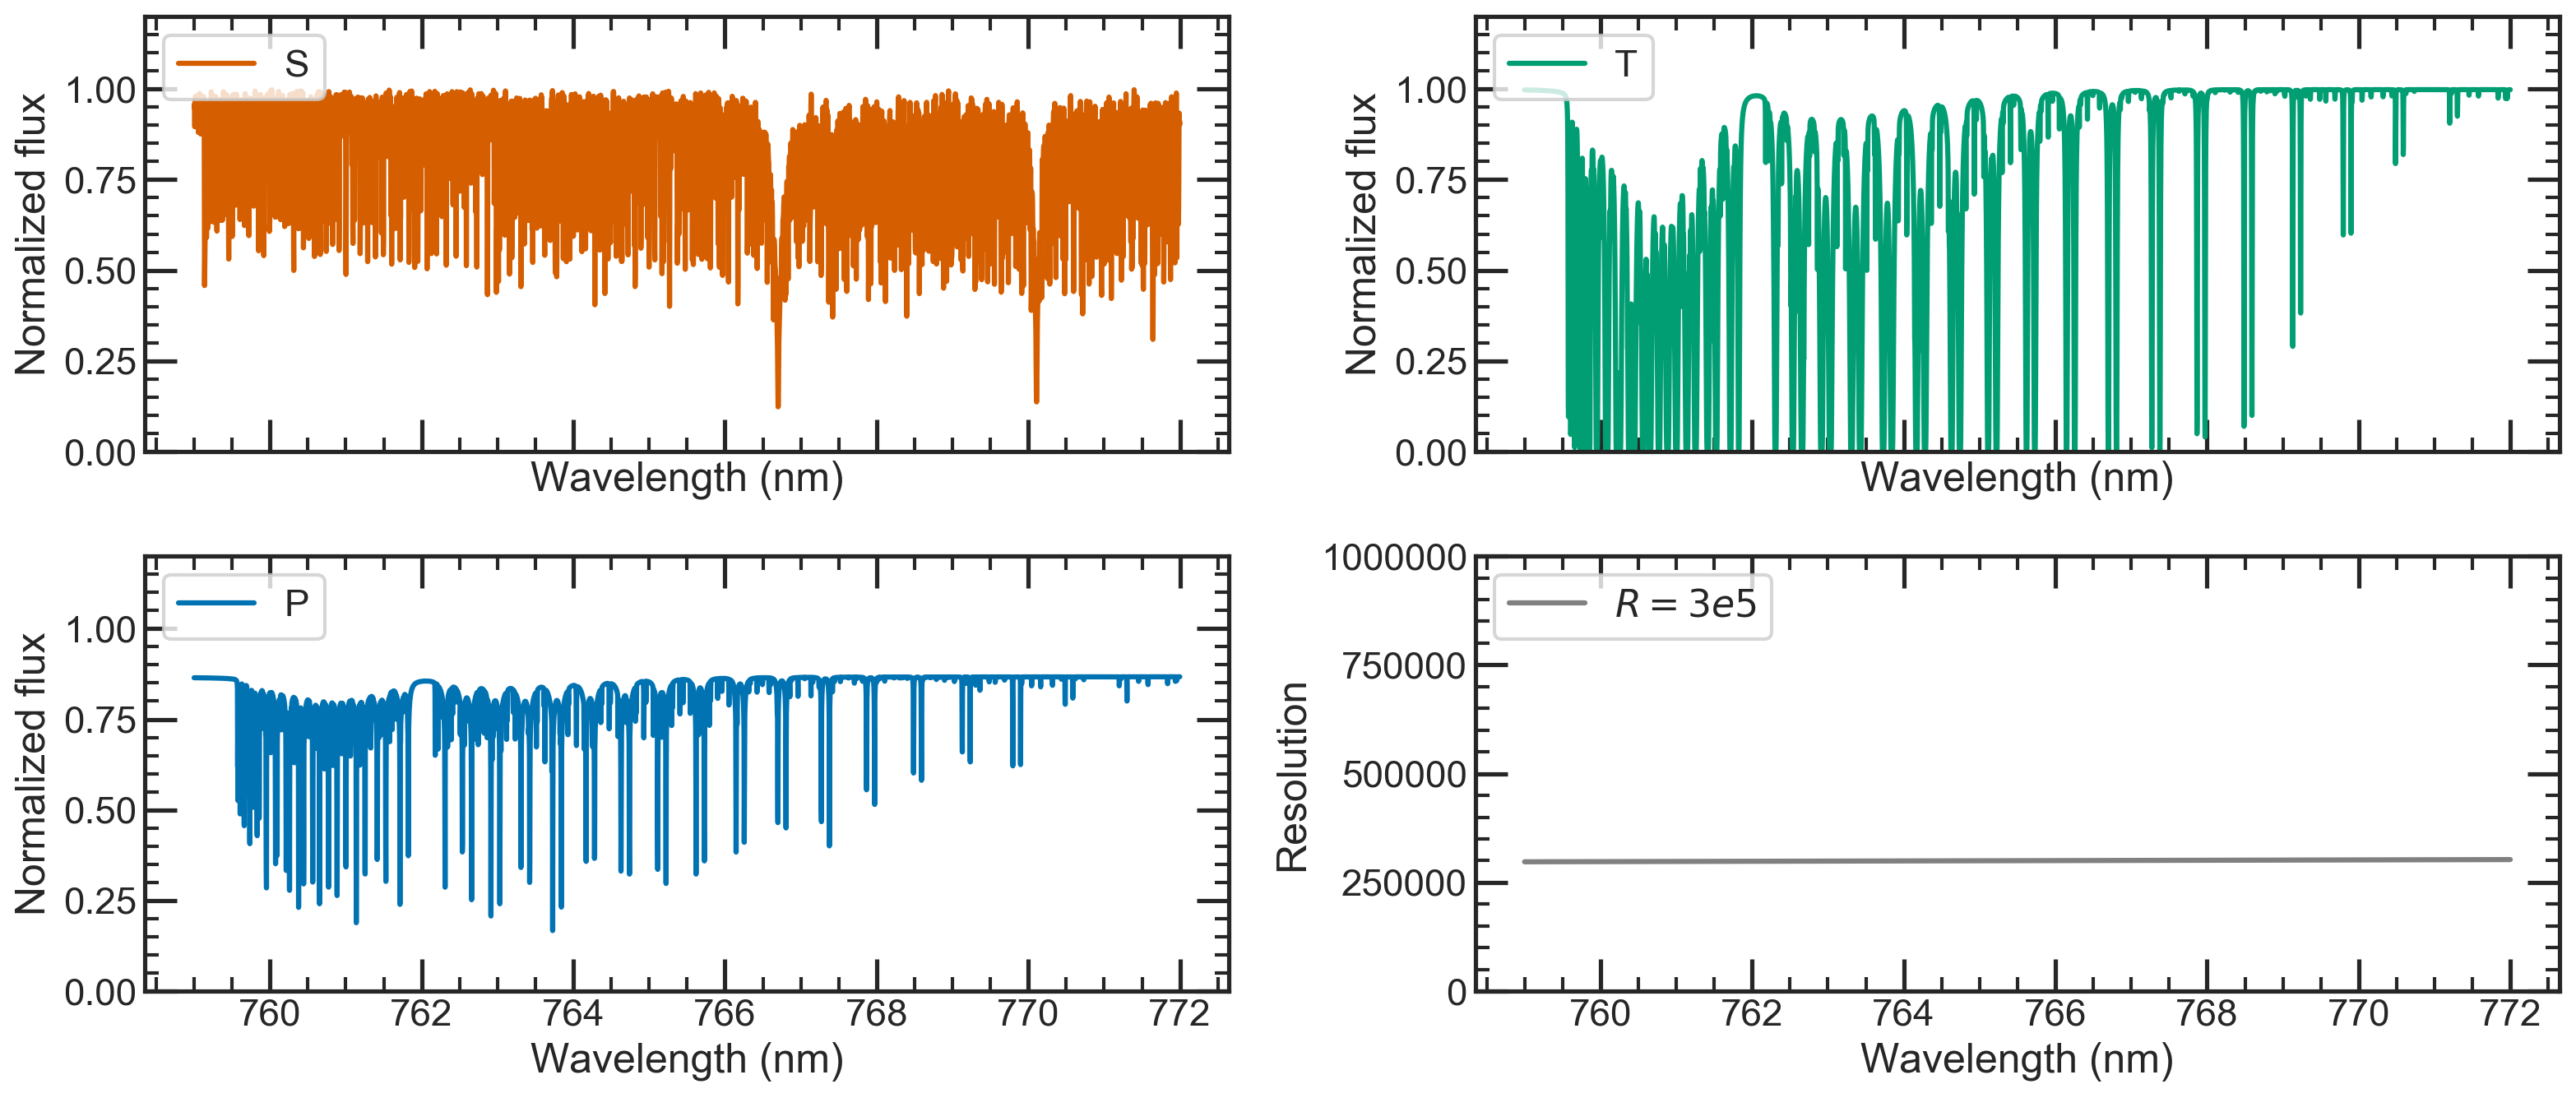

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
ax_STP, ax_res = axes.flatten()[:3], axes.flatten()[-1]

R = "3e5"
###########
# STP plots
###########
colors = ['r', 'g', 'b']
wav = data_resampled[R]["wav"]
for ax, d, c in zip(ax_STP, data_resampled[R].items(), colors):
    if d[0] != "wav":
        ax.plot(wav*1e7, d[1]["flux"], color=c, label=d[0])
        # Make some space at the top for the legend
        [ax.set_ylim(0, 1.2) for ax in ax_STP]
        ax.legend(loc=2, ncol=3)
        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylabel("Normalized flux")
        
#################
# Resolution plot
#################
res = utils.get_R(wav)
ax_res.plot(wav*1e7, res, c='grey', label=f"$R = {R}$")

ax_res.yaxis.set_ticks(np.linspace(0, 1e6, 5))
ax_res.legend(loc=2, ncol=3)
ax_res.set_xlabel("Wavelength (nm)")
ax_res.set_ylabel("Resolution")

fig.tight_layout()

Looks good. Now we can replicate Fig 1.

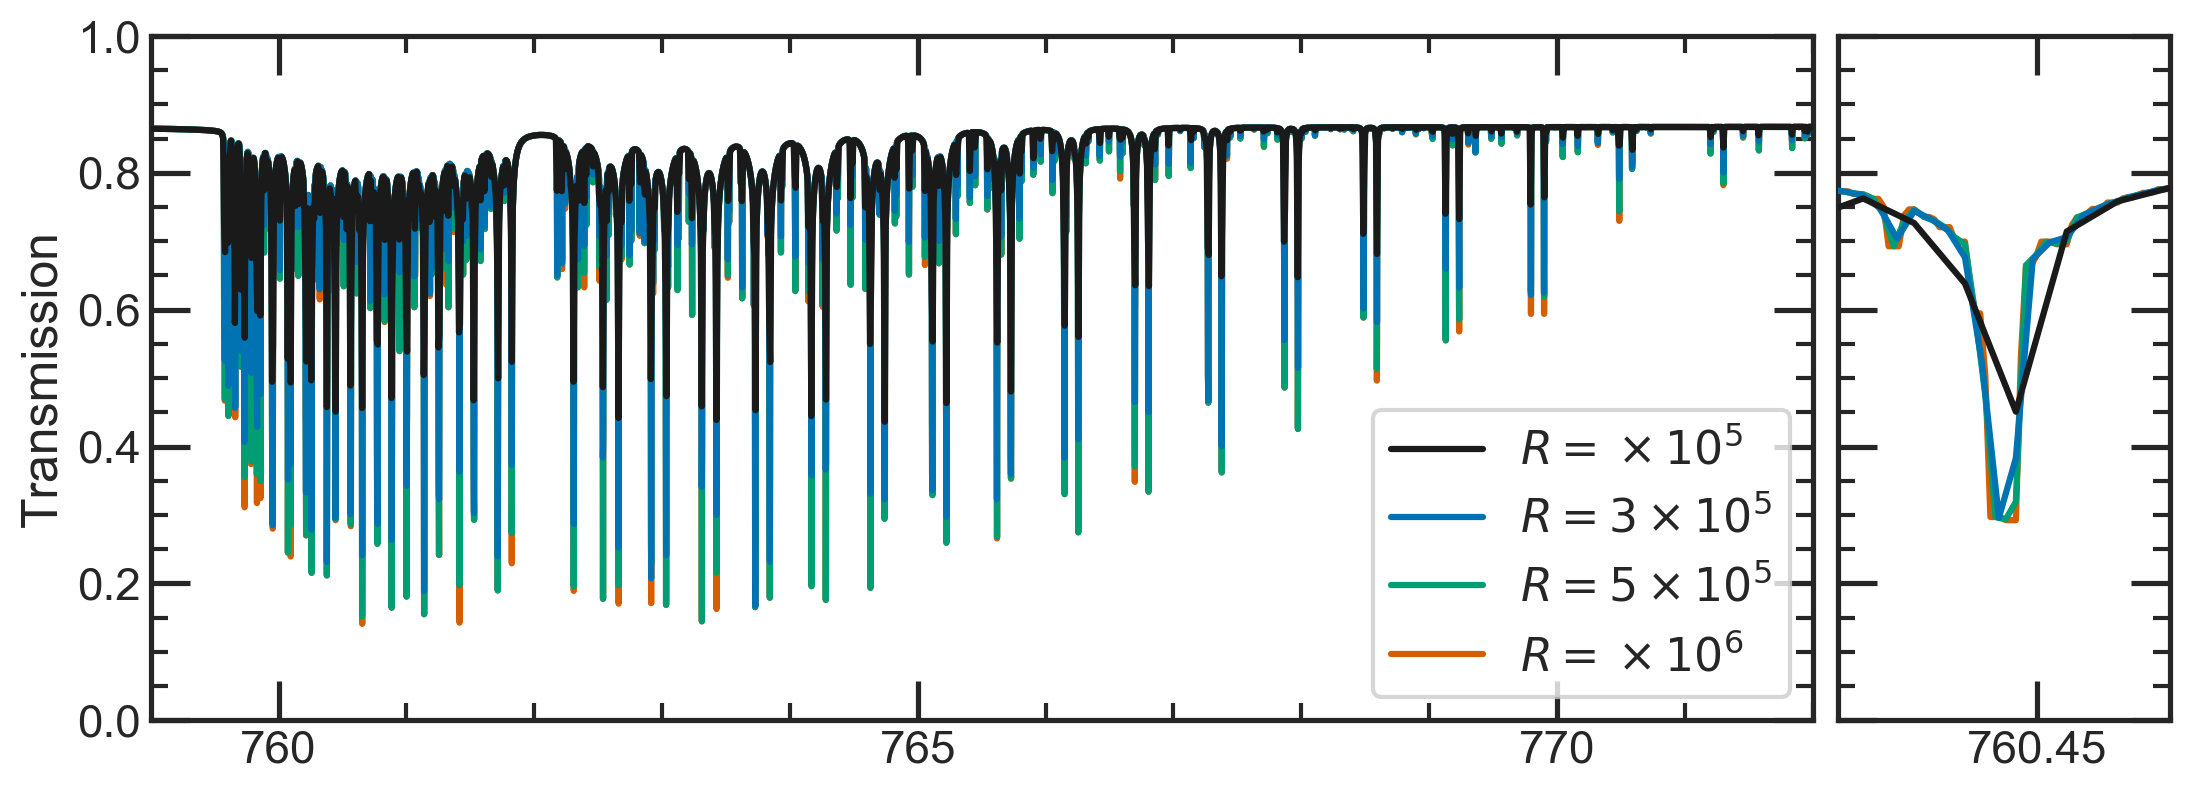

In [12]:
fig, axes = plt.subplots(
    1, 2, figsize=(11, 4), sharey=True, 
    gridspec_kw={'width_ratios': [5, 1]}
)
ax_left, ax_right = axes.flatten()

colors = ['k', 'b', 'g', 'r']
zorders = [4, 3, 2, 1]
for d, c, z in zip(data_resampled.items(), colors, zorders):
    wav, flux = d[1]["wav"], d[1]['P']["flux"]
    ax_left.plot(
        wav*1e7, flux, c, 
        zorder=z, label=f"$R = {num2tex(d[0], precision=2)}$",
    )
    ax_right.plot(
        wav*1e7, flux, c, 
        zorder=z, label=f"$R = {num2tex(d[0], precision=2)}$",
    )
# Use same axis limits in paper
ax_left.set_xlim(759, 772)
ax_left.xaxis.set_ticks(np.arange(760, 773, 5))
ax_left.set_ylabel("Transmission")
ax_left.legend(loc=4)    
ax_right.set_xlim(760.42, 760.47)
ax_right.xaxis.set_ticks([760.45])
ax_right.set_ylim(0, 1)
 
fig.tight_layout(pad=0.5)
#plt.savefig("/Users/mango/Desktop/o2_lines.png", dpi=250, bbox_inches="tight")

## Doppler Shift

Finally, we'll want to be able to Doppler shift our S and P spectra, based on the systemic velocity of a particular system. This can be done with `pyasl.dopplerShift`, which we will use with an example velocity of $20\text{ km/s}$ and $R = 3\times10^5$:

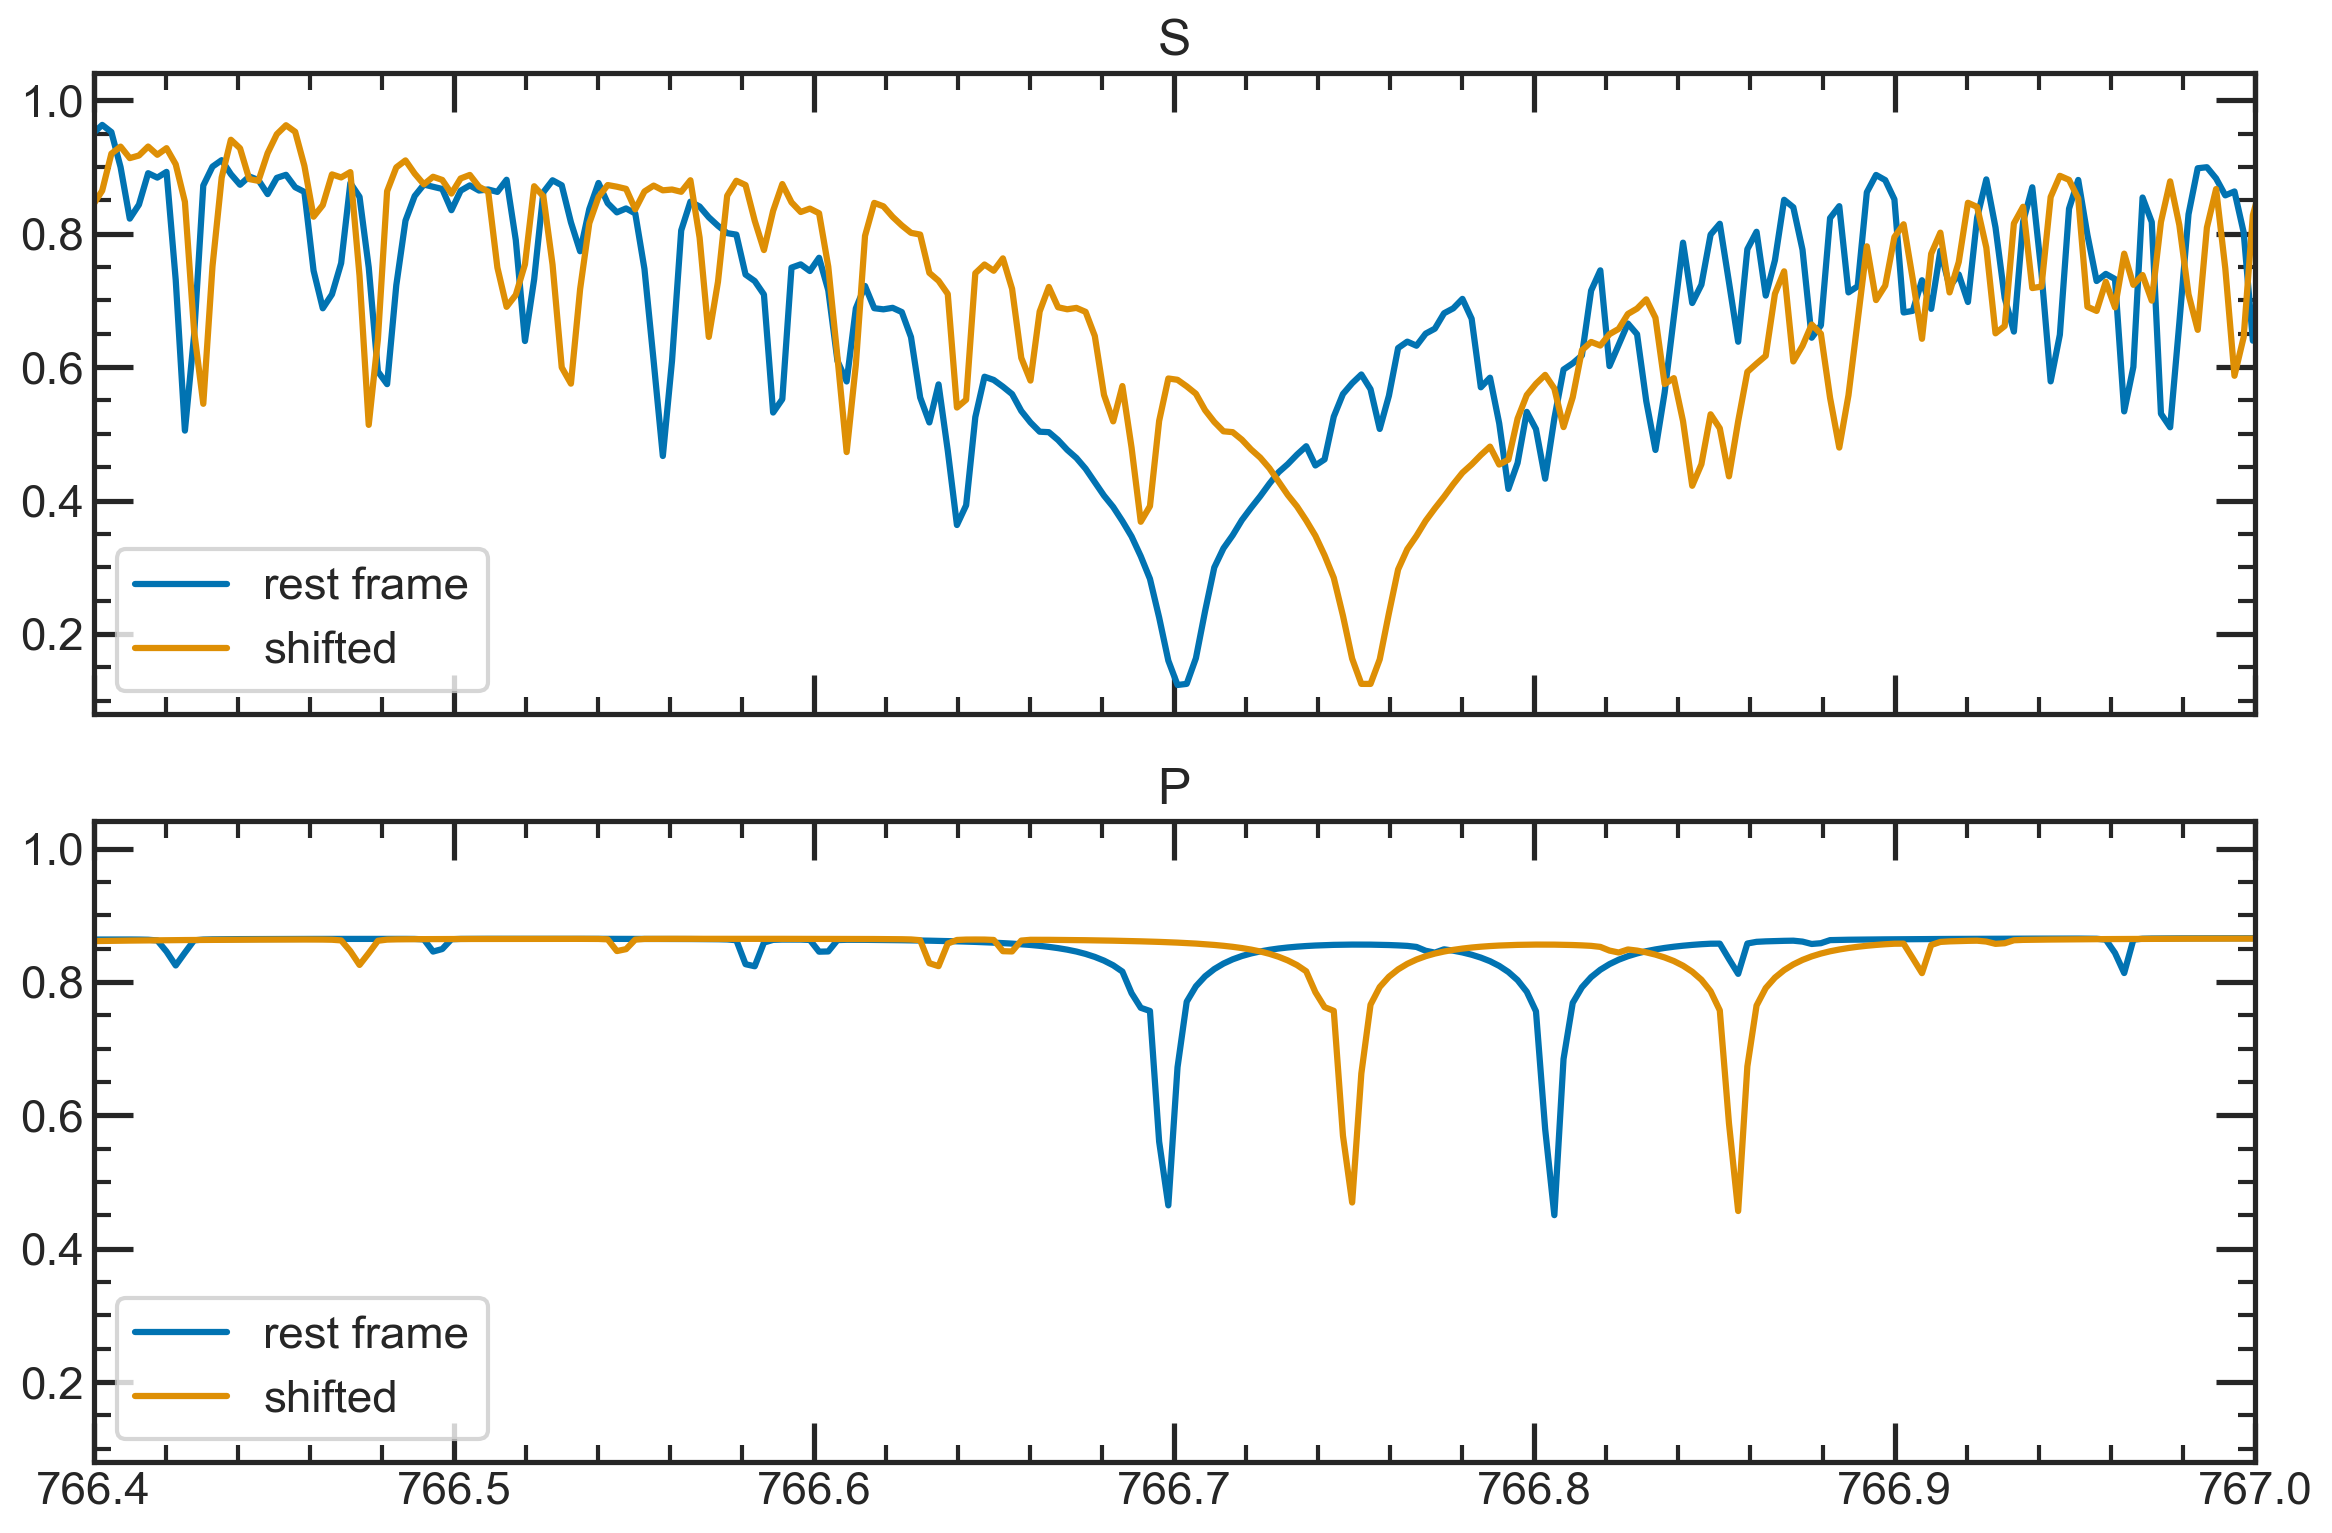

In [13]:
v_system = 20
R = "3e5"
data_resampled[R]['S']["flux_shifted"], _ = pyasl.dopplerShift(
                                                data_resampled[R]["wav"], 
                                                data_resampled[R]['S']["flux"], 
                                                v_system, 
                                                edgeHandling="firstlast",
                                                )
data_resampled[R]['P']["flux_shifted"], _ = pyasl.dopplerShift(
                                                data_resampled[R]["wav"], 
                                                data_resampled[R]['P']["flux"], 
                                                v_system, 
                                                edgeHandling="firstlast",
                                                )

######
# Plot
######
fig, axes = plt.subplots(2, 1, figsize=FIG_LARGE, sharex=True, sharey=True)

wav = data_resampled[R]["wav"]
models = ['S', 'P']
for ax, model in zip(axes, models):
    flux = data_resampled[R][model]["flux"]
    flux_shifted = data_resampled[R][model]["flux_shifted"]
    ax.plot(wav*1e7, flux, label="rest frame")
    ax.plot(wav*1e7, flux_shifted, label="shifted")
    
    ax.set_title(model)
    ax.legend(loc=3)
    
axes[-1].set_xlim(766.4, 767.0)

fig.tight_layout()

Cool, it looks like the wavelength shift is about 0.05 nm, which corresponds to $v = 20 \text{km/s}$.

## CCF check

The next thing we'll want to do is run a cross-correlation (`pyasl.crosscorrRV`) of $P_\text{obs}$ with a template spectrum. To make sure our machinery is working as expected, let's try it out on all three of our model spectra:

Text(0.5, 0, 'velocity (km/s)')

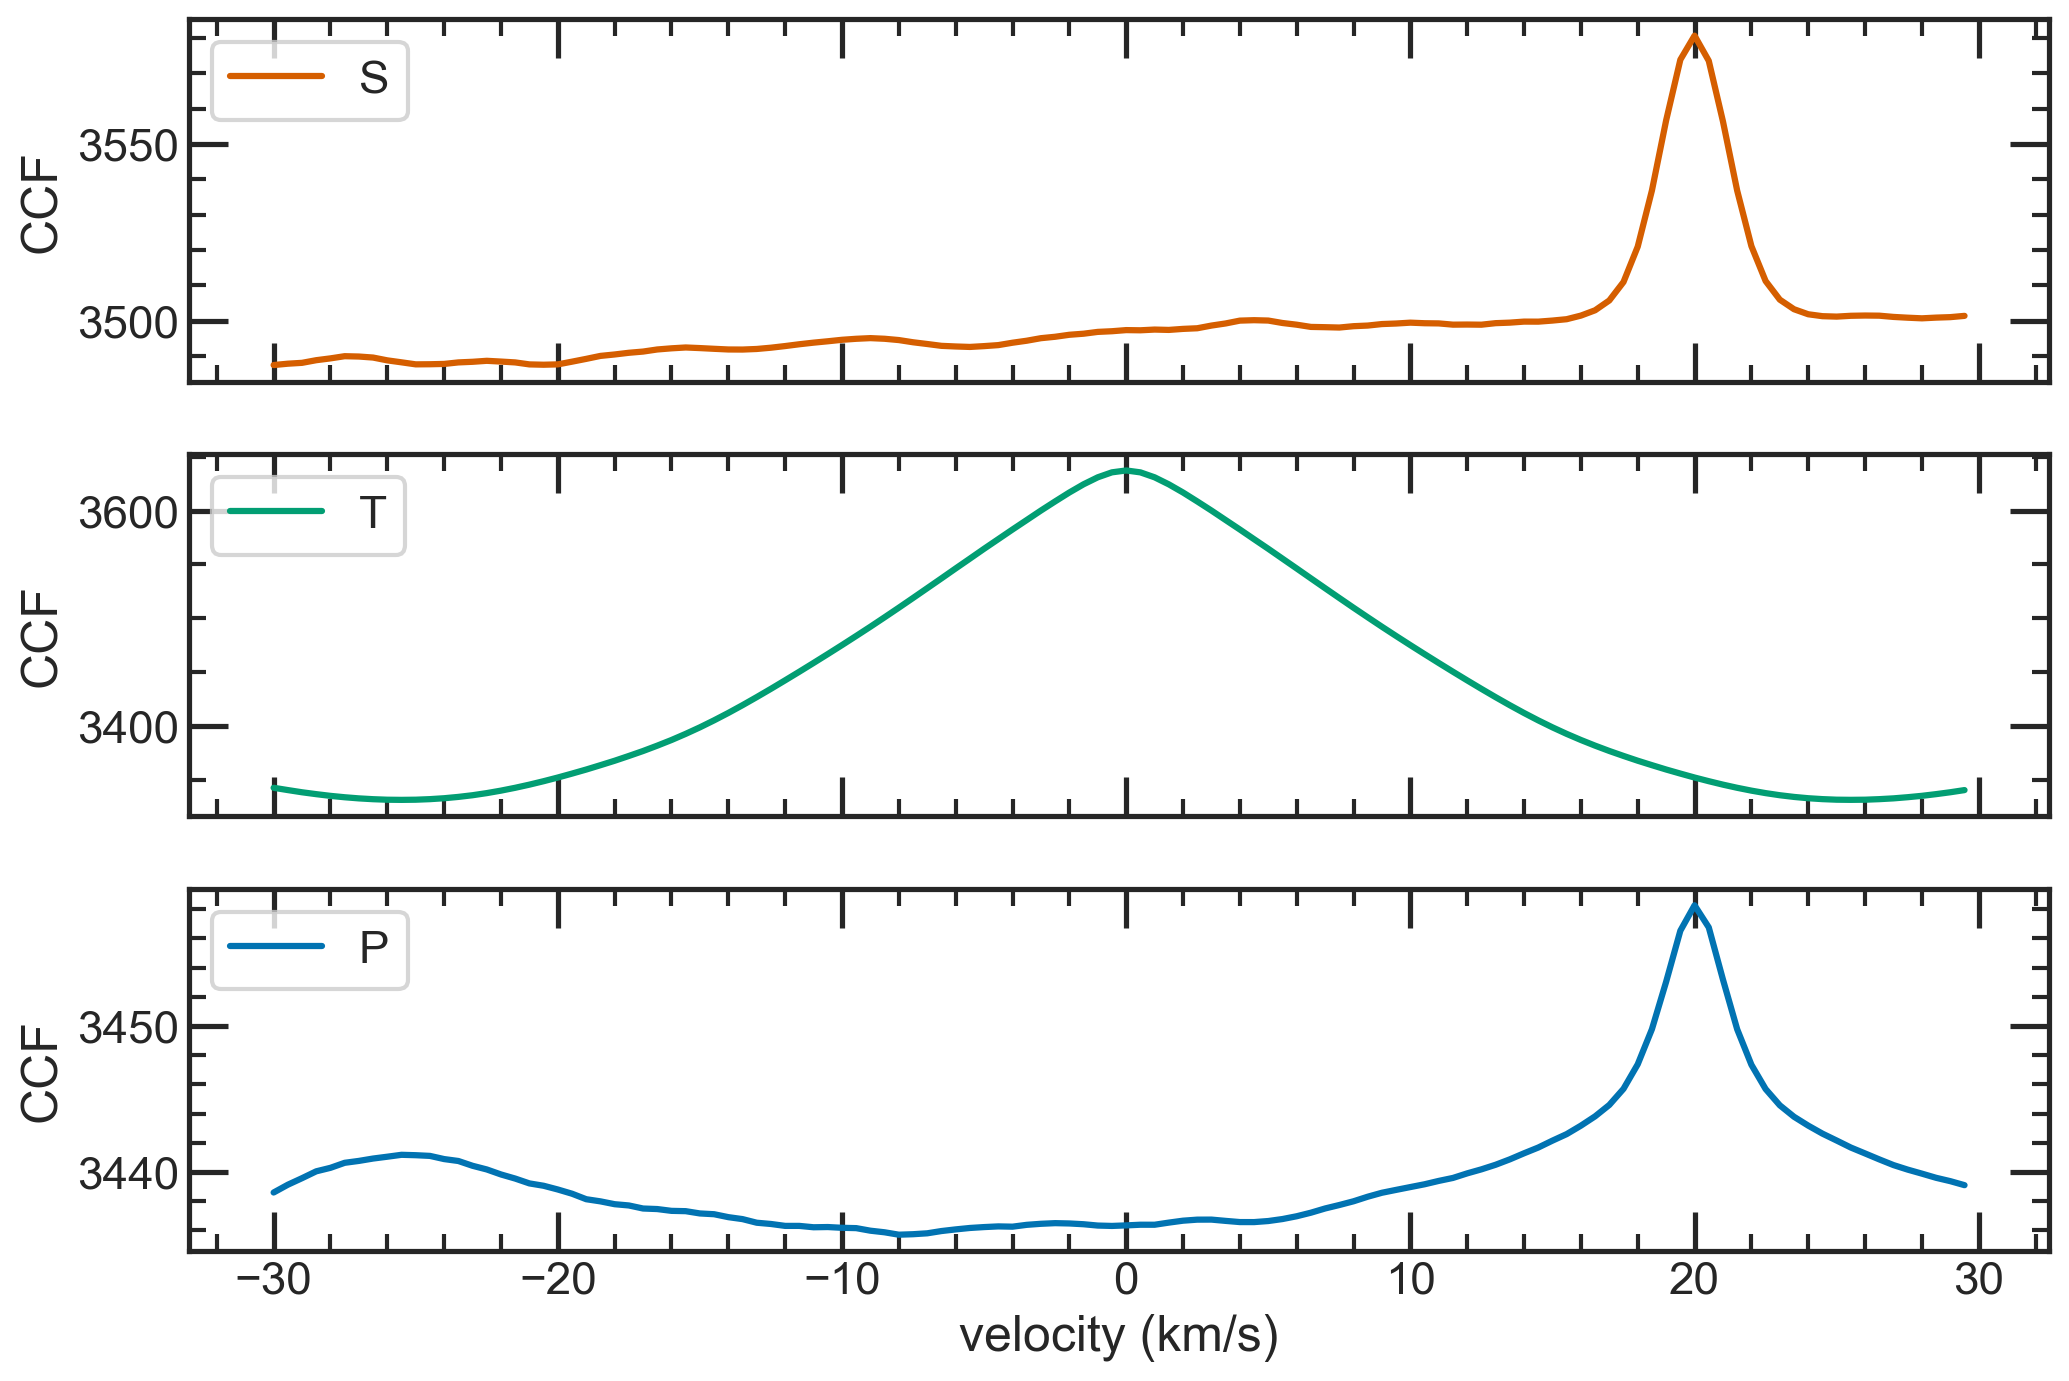

In [17]:
fig, axes = plt.subplots(3, 1, figsize=FIG_LARGE, sharex=True)

models = ['S', 'T', 'P']
colors = ['r', 'g', 'b']
for ax, model, color in zip(axes, models, colors):
    # Run the CCF
    wav = data_resampled[R]["wav"]
    if model == 'T':
        flux = data_resampled[R][model]["flux"]
    else:
        flux = data_resampled[R][model]["flux_shifted"]
    template_wav = data[model]["wav"]
    template_flux = data[model]["flux"]
    rv, cc = pyasl.crosscorrRV(
                 wav, flux, # spectrum 1
                 template_wav, template_flux, # spectrum 2
                 -30, # lower bound velocity shift
                 30,  # upper bound velocity shift
                 0.5, # velocity increment
             )

    # Plot
    ax.plot(rv, cc, c=color, label=model) 
    ax.set_ylabel("CCF")
    ax.legend(loc=2)
    
axes[-1].set_xlabel("velocity (km/s)")

As expected, the model spectra have the highest correlation with their respective template spectrum when the template is shifted by our input amount.

## Generate

Now that we have all of the ingredients, we can cross correlate $\tilde C$ with a Gaussian instrument profile $(G)$, with 
$\text{FWHM} = 2\sqrt{2\ln 2}\sigma$ to simulate the final observed spectrum:

\begin{align}
P_\text{obs}^{(0)} = C_\text{in}^{(0)} / C_\text{out}^{(0)} \quad,
\end{align}

where "in"/"out" are the in-transit/out-of-transit variants of $C$ (i.e., the "out" variant is just the "in" variant with $P \equiv 0$). Note: The zero superscript is to make it explicit that this has only been computed for a single transit (N=1). The non-superscripted variants are reserved for integrating more than a single transit, sampled randomly from a pool of possible models. This is part of the bootstrapping process that will be examined next.

Both cases (single and multiple transits) use `utils.get_C` to generate the initial model, and an example for a typical M4V system 
$(R = 3\times10^5,\ \epsilon=3.5\times10^4,\ v_*=2\times10^6\text{ cm/s})$ is shown below for a single transit: 

**(TODO: Scale flux to 5pc)**

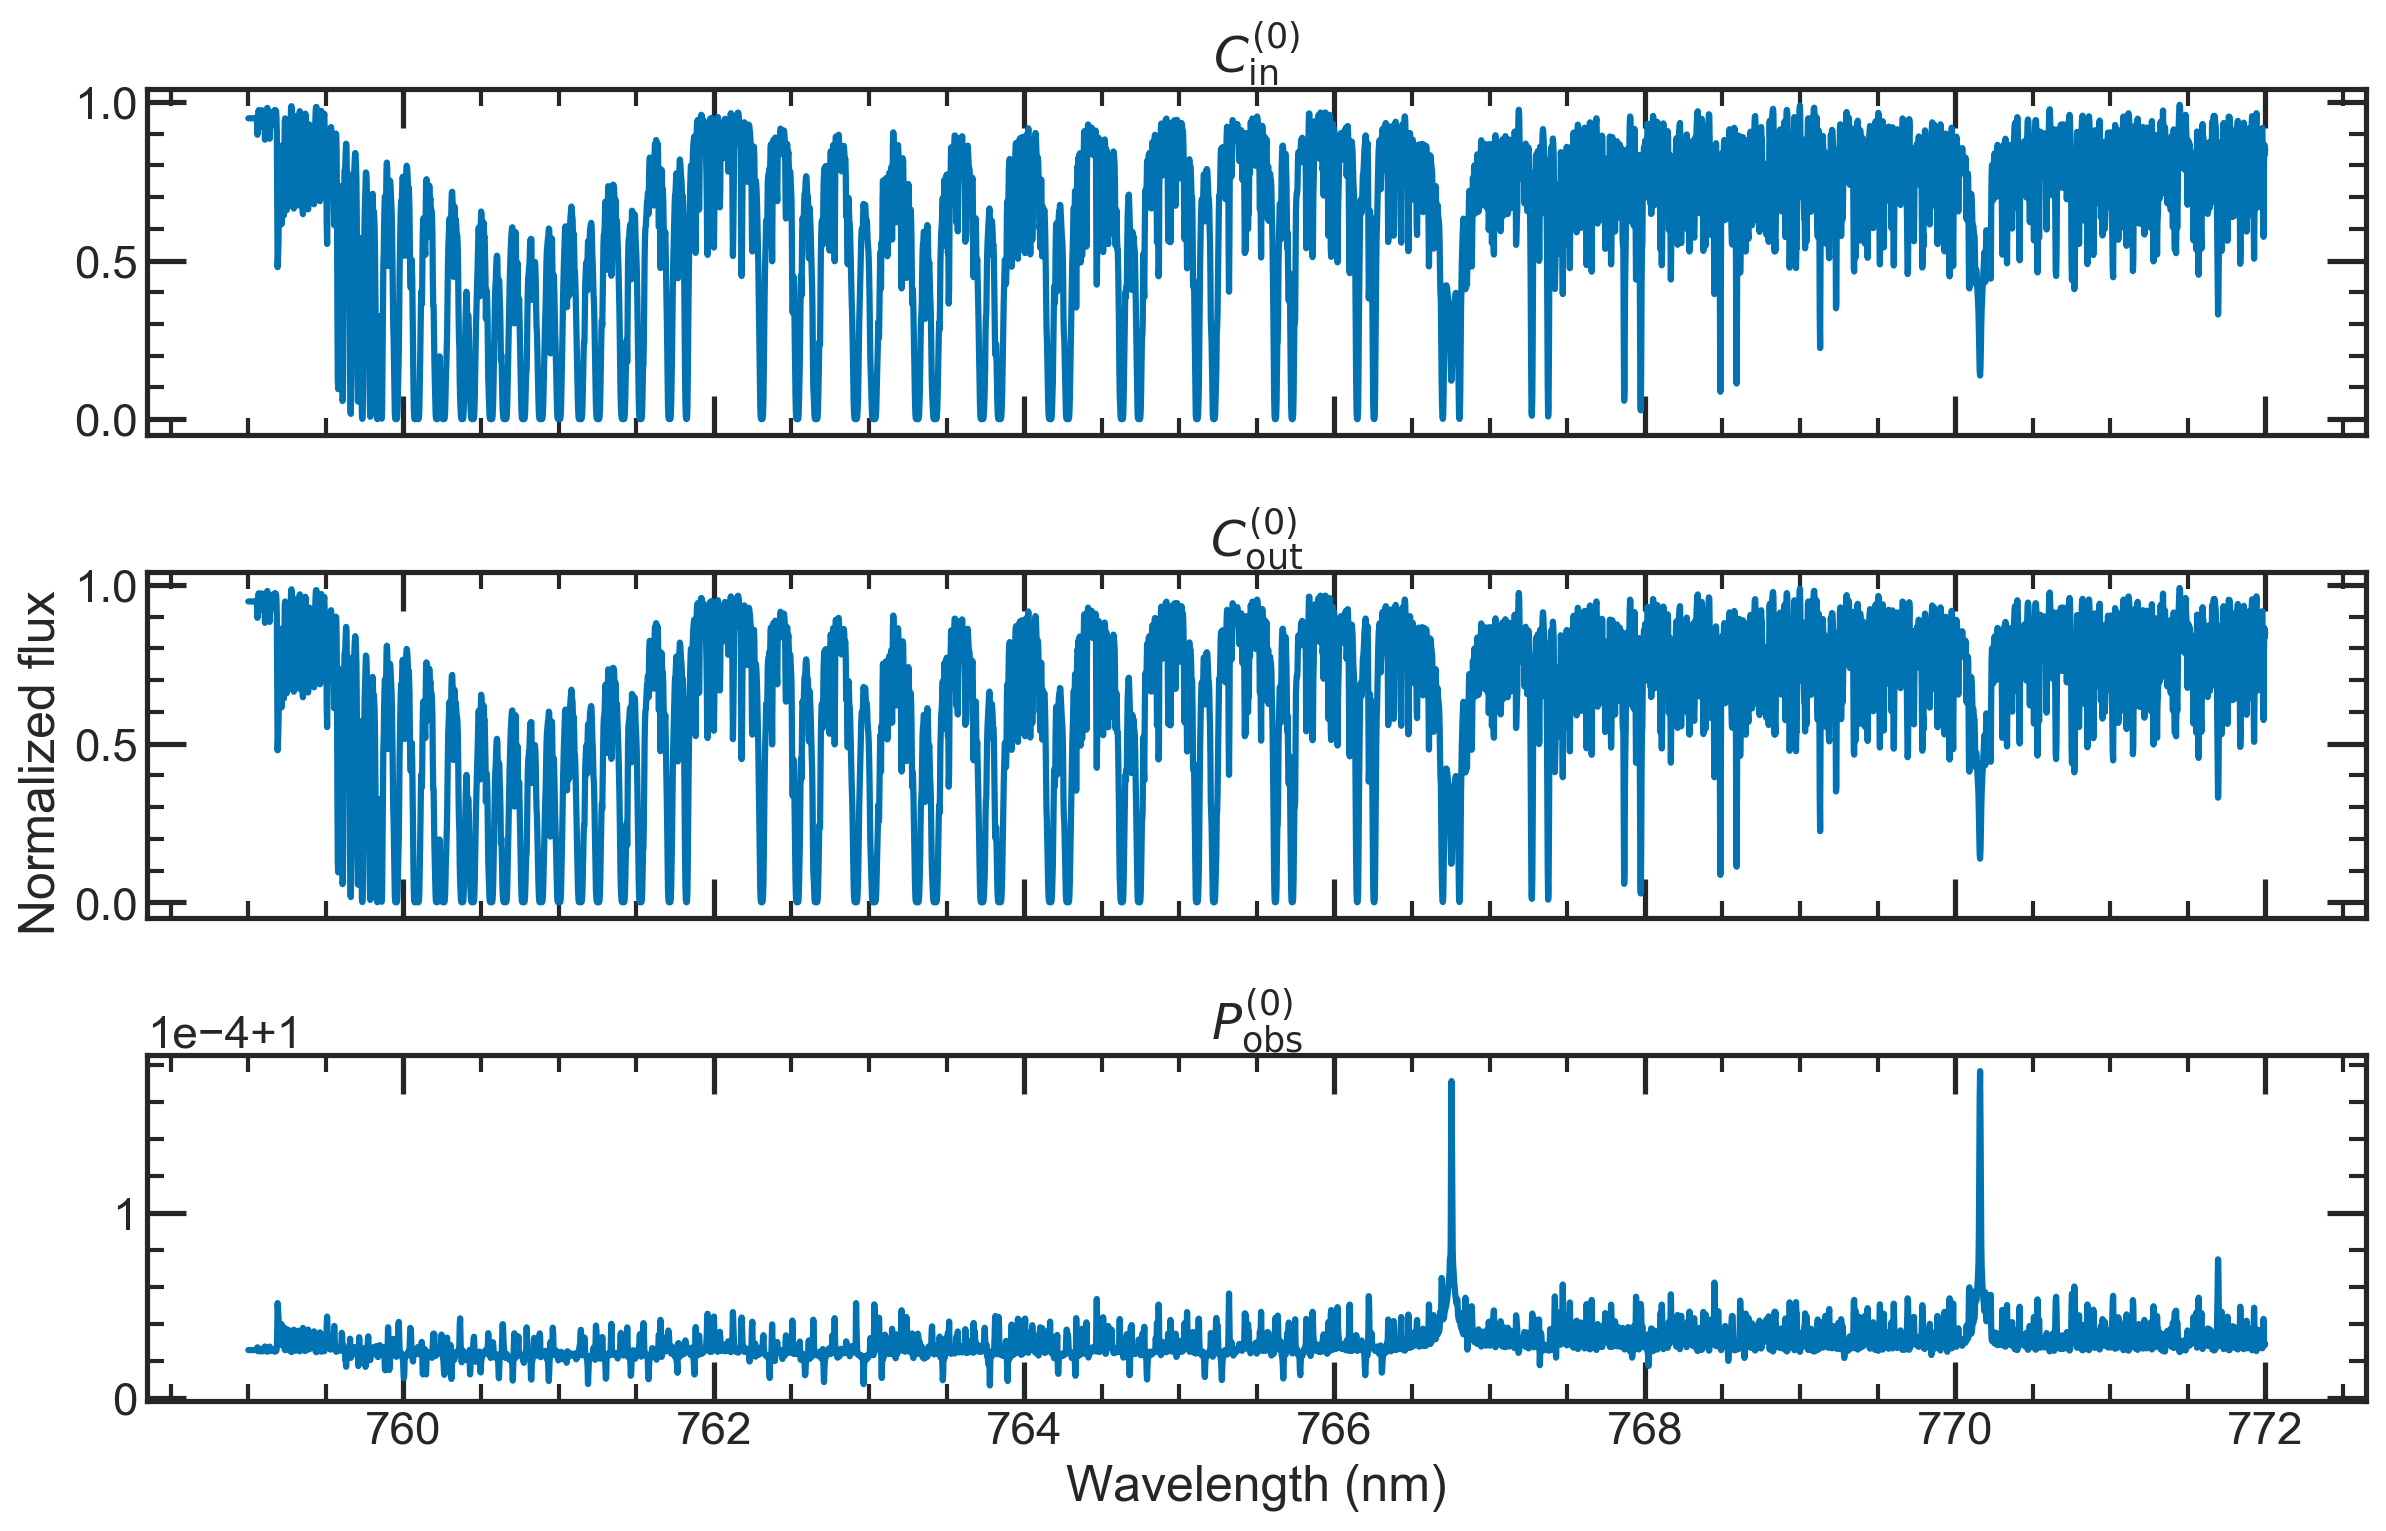

In [18]:
# Compute P_obs
R = "3e5" # Resolution
C_in_model, C_out_model, C_inputs = utils.get_C(
    float(R),
    wav=data_resampled[R]["wav"], 
    wav_band=data_resampled["wav_band"],
    flux_S=data_resampled[R]['S']["flux_shifted"], 
    flux_T=data_resampled[R]['T']["flux"], 
    flux_P=data_resampled[R]['P']["flux_shifted"], 
)
P_obs_model = C_in_model / C_out_model

######################################################
# Plot C_in, C_out, and P_obs model for single transit
######################################################
fig, axes = plt.subplots(3, 1, figsize=FIG_LARGE, sharex=True)

wav = data_resampled[R]["wav"]
P_obs_model = C_in_model / C_out_model

titles = [
    "$C_\\mathrm{{{in}}}^{{(0)}}$",
    "$C_\\mathrm{{{out}}}^{{(0)}}$",
    "$P_\\mathrm{{{obs}}}^{{(0)}}$"]
models = [C_in_model, C_out_model, P_obs_model]
for ax, model, title in zip(axes, models, titles):
    ax.plot(wav*1e7, model)
    ax.set_title(title)
    
axes[-1].set_xlabel("Wavelength (nm)")
fig.text(0.0, 0.5, 'Normalized flux', va="center", rotation='vertical')

fig.tight_layout()

The sample models above have these values for the following internal inputs computed in `utils.get_C`:

`coeff_S` = $1 + v_*/c$

`coeff_T` = $(1 + \epsilon^{-1})^{-1}$

`coeff_P` = $\left(1 + (v_* + v_\text{pl}) c^{-1}\right) \epsilon^{-1}$

`a_in` = `coeff_S`$\times S$ + `coeff_P`$\times P$

`a_out` = `coeff_S`$\times S$

`C_tilde_in` = `a_in`$\times$ `coeff_T`$\times T$

`C_tilde_out` = `a_out`$\times$ `coeff_T`$\times T$

`wav_central` = (`wav_band`[0] + `wav_band`[1])/2 (Stored in inputted `data_resampled`)

`FWHM` = `wav_central` / $R$

`sigma` = `FWHM` / $2\sqrt{2\ln 2}$

In [19]:
C_inputs

{'coeff_S': 1.0000666666666667,
 'coeff_T': 0.9999714293877318,
 'coeff_P': 2.8573333333333333e-05,
 'a_in': array([0.95050665, 0.95050665, 0.95050665, ..., 0.87224515, 0.83388332,
        0.85342609]),
 'a_out': array([0.95048195, 0.95048195, 0.95048195, ..., 0.87222044, 0.83385854,
        0.85340131]),
 'C_tilde_in': array([0.9480323 , 0.94802321, 0.94801406, ..., 0.87054806, 0.83227007,
        0.85178186]),
 'C_tilde_out': array([0.94800766, 0.94799857, 0.94798943, ..., 0.87052341, 0.83224534,
        0.85175713]),
 'wav_central': 7.654999999999999e-05,
 'FWHM': 2.551666666666666e-10,
 'sigma': 1.0835930635341307e-10}

### How many photons?

Before performing the full bootstrapping analysis, let's look at how doing the above for multiple transits would work.
 
 <br>

We want to simulate performing an observation each night, which we can accomplish by adding random noise to our observations each night. For starters, this will just be the Poisson white noise
\begin{align}
\sigma_\text{w} = \sqrt{N_\text{ph}} \quad,
\end{align}

where $N_\text{ph}$ is the total number of photons we collect in a single night of observing. Let's find this.

<br>

The relation between flux, magnitude, and distance is
\begin{align}
m_1 - m_2 = - 2.5\log(F_1/F_2) = m_2 + 5\log(d_1/d_2) \quad, 
\end{align}

where $d$ is the distance the star is away from Earth in $\text{pc}$ and $F$ is the corresponding monochromatic flux. Setting the zero-point to $F_2(m_2=0)$, the received flux is then

\begin{align}
F_1 = 10^{-m_1 / 2.5} F_2 \text{ erg}\text{ cm}^{-2}\text{ s}^{-1}\text{ Å}^{-1}
\quad.
\end{align}

In the bandpass spanned by $\Delta\lambda$, the total number of photons
(with average energy $E = hc/\lambda_0$, for an effective wavelength $\lambda_0$) received by a telescope on Earth with an effective collecting aperture $D$ in a time $\tau$ would then be about

\begin{align}
N_\text{ph}(F_2, m_1, \tau, \Delta\lambda, \lambda_0, D) 
= F_1 \cdot \tau \cdot \Delta\lambda \cdot \frac{1}{E} \cdot \pi(D/2)^2 \quad.
\end{align}

This is implemented in `utils.count_photons` and is shown for a typical observation of an $M4V$ star:

In [20]:
observation_params = {
    "d_1":5*u.pc, # Distance
    "m_2":10.0, # Absolute magnitude
    'D':25.448*u.m, # Diameter of GMT
    "tau":2*u.hr, # Duration of observation
    "delta_lambda":149*u.nm, # I-band
    "lambda_0":806*u.nm, # I-band central wavelength
    }

# Get total number of photons collected
N_ph = utils.count_photons(**observation_params)

print(f"{N_ph:.3e}")

1.010e+13


The white noise would then go like

In [39]:
sigma_w = 1./np.sqrt(N_ph)

print(f"{sigma_w:.3e}")

3.147e-07


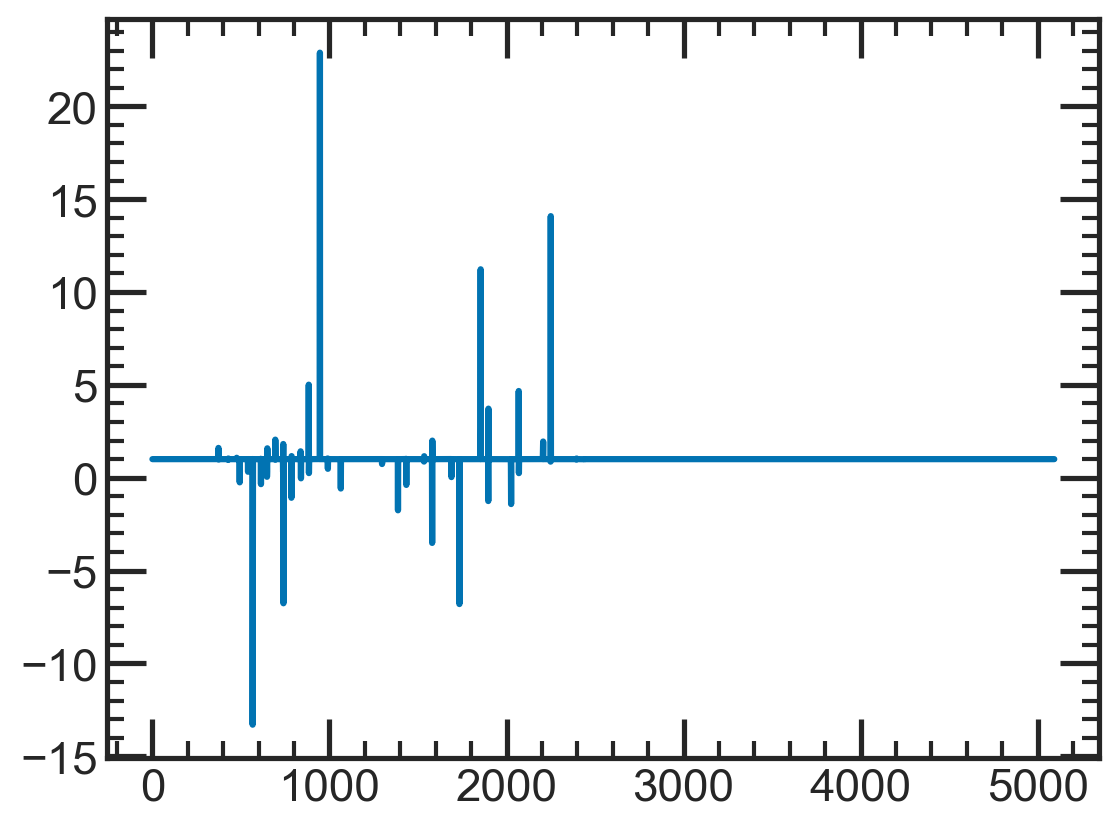

In [44]:
R = "3e5"
I = 1_000 # size of pool
N = 24 # number of transit samples from pool
P_obs, inputs = utils.get_P_obs(
                    R=float(R),
                    I=I,
                    N=N,
                    sigma_w=sigma_w,
                    wav=data_resampled[R]["wav"],
                    wav_band=data_resampled["wav_band"],
                    flux_S=data_resampled[R]['S']["flux_shifted"],
                    flux_T=data_resampled[R]['T']["flux"],
                    flux_P=data_resampled[R]['P']["flux_shifted"],
                )

fig, ax = plt.subplots()
ax.plot(P_obs)

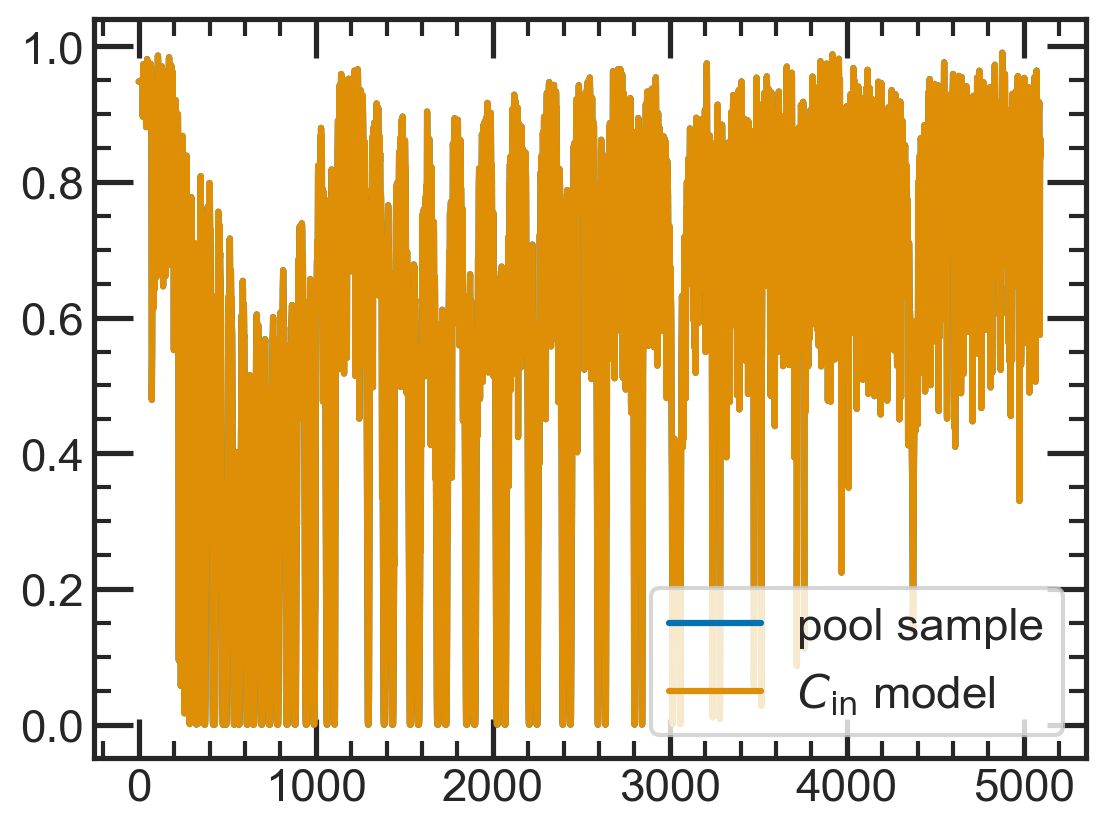

In [45]:
fig, ax = plt.subplots()
ax.plot(inputs["in_transit_pool"][30, :], label="pool sample")
ax.plot(inputs["C_in_model"], label="$C_\mathrm{in}$ model")
ax.legend(loc=4)

# Bootstrap Analysis

Now let's go ahead and try and replicate part of Figure 4 by following the bootstrap analysis outlined in Section 3.2. Here is the recipe used for this bootstrap:

1. Generate a pool of $I=1000$ model spectra $(C)$ with random noise sampled from $\mathcal N \sim Gauss(0, \sigma_w)$ for each model
1. Randomly select $N$ spectra, where $N$ is the number of in-transit observations (x-axis)
1. Produce an observed planet spectrum $P_\text{obs} = C_\text{in}/C_\text{out}$, where $C_\text{in}$ is the in-transit integrated spectra obtained from summing up the model spectra selected in the previous step. $C_\text{out}$ is the out-of-transit spectra obtained by summing up $N$ random stellar $(S)$ and telluric $(T)$ spectra alone, also with randomized noise values
1. Get CCF by cross-correlating $P_\text{obs}$ (after Doppler shifting it) with a noiseless, template exoplanet spectrum $(P)$
1. Obtain detection significance (y-axis, $\sigma$) by examining peak in the CCF at $v_* = 20 \text{ km/s}$, which is the input velocity of the system in the models. This is done with the following bootstrap:
    1. Repeat steps 2-4 $M=500$ times
    1. Calculate $\text{FAP}=\frac{m}{M}$, where $m$ is the number of models out of the $M$ iterations where $20 - \epsilon \le v_\text{max} \le 20 + \epsilon \text{ km/s}$ in CCF for some small $\epsilon$
1. Compute detection significance $\sim 1 - \text{FAP} = 1 - \frac{m}{M}$. For a 3-sigma confidence level, this corresponds to 1 - FAP = 0.9973. In other words, 
if $\text{FAP} <= 0.0027$, we can say that oxygen has been detected after $N$ observed transits with 3-sigma confidence 

<br>

`utils.get_CCF` handles steps 1-4

In [ ]:
# CCF params
R = "3e5"
wav = data_resampled[R]["wav"]
S = data_resampled[R]['S']["flux_shifted"]
T = data_resampled[R]['T']["flux"]
P = data_resampled[R]['P']["flux_shifted"]
P0_wav = data['P']['wav']
P0_flux = data['P']['flux']
wav_band = data_resampled["wav_band"]
I = 1_000 # size of pool
N = 24 # number of transit samples from pool
sigma_w = 1e-8

# Compute
CCF_data = utils.CCF_data(
    wav,
    wav_band,
    float(R),
    S, T, P,
    P0_wav, P0_flux,
    sigma_w, I, N
)
# Unpack keys
wav = CCF_data["wav"]
C_in = CCF_data["C_in"]
C_out = CCF_data["C_out"]
P_obs = CCF_data["P_obs"]
template_wav = CCF_data["template_wav"]
template_flux = CCF_data["template_flux"]
rv, cc = pyasl.crosscorrRV(wav, P_obs,
                           template_wav, template_flux,
                           -30, 30, 0.5)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(rv, cc)
#ax.plot(wav*1e7, C_in, label="C_in")
#ax.plot(wav*1e7, C_out, label="C_out")
#ax.plot(wav*1e7, C_in - C_out, label="C_in-C_out")
#ax.plot(wav*1e7, P_obs)
#plt.plot(template_wav, template_flux)

ax.legend(loc=4)
#ax.set_xlabel("velocity (km/s)")
#ax.set_ylabel("normalized flux")
fig.tight_layout()

In [ ]:
# Plot
#plt.plot(CCF_data["rv"], CCF_data["cc"])
plt.plot(CCF_data["wav"]*1e7, CCF_data["P_obs"], label="P_obs")
plt.plot(CCF_data["template_wav"]*1e7, CCF_data["template_flux"], label="template")
#plt.plot(wav*1e7, CCF_data["C_tilde_in_model"], label="C_tilde_in_model")
#plt.plot(wav*1e7, CCF_data["C_in_model"], label="C_in_model")
#plt.plot(wav*1e7, CCF_data["C_in"], label="C_in")
#plt.plot(wav*1e7, CCF_data["C_out"], label="C_out")
#plt.xlim(768.5, 769.10)
plt.legend(loc=3)

In [ ]:
plt.plot(np.sum(CCF_data["in_transit_samples"], axis=0))

In [ ]:
plt.plot(wav*1e7, S, label='S')
plt.plot(wav*1e7, T, label='T')
plt.plot(wav*1e7, P, label='P')
plt.legend(ncol=3, loc=2)

## FAP

In [ ]:
CCF_data = utils.pkl_load("output.pkl")

fig, ax = plt.subplots(figsize=(11, 6))

for sigma_w in np.flip(list(CCF_data.keys())):
    v_maxs = [CCF_data[sigma_w][idx]["v_max"] for idx in CCF_data[sigma_w].keys()]
    v_maxs = np.array(v_maxs)

    system_v = 20
    delta_v = 0.5
    fap_cond = (system_v-delta_v <= v_maxs) & (v_maxs <= system_v+delta_v)
    m = v_maxs[fap_cond].size
    M = v_maxs.size

    sigma_w = float(sigma_w)
    label = f"$\sigma_w = {sigma_w},\ \mathrm{{FAP}} = {m}/{M} = {m/M}$"
    ax.hist(v_maxs, lw=0.1, alpha=0.75, label=label, bins=30)

ax.axvspan(system_v - delta_v, system_v + delta_v, alpha=0.5, color="w", lw=0)
    
ax.legend(loc=2, fontsize=12)
ax.set_xlim(-150, 150)
ax.set_ylim(0, 350)
#ax.set_title(f"$\mathrm{{FAP}} = {m}/{M} = {m/M}$")
ax.set_xlabel("maximum velocity (km/s)")
ax.set_ylabel("count")

dirpath = "/Users/mango/Desktop/figs"
fname = f"vmax_sigma_w.png"
#fig.savefig(f"{dirpath}/{fname}", bbox_inches="tight", dpi=250)

## CCF vs. model number

In [ ]:
CCF_data["1e-09"][0].keys()

In [ ]:
i = 30
plt.plot(CCF_data["1e-09"][i]["P_obs"])

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

xfield, yfield = "rv", "cc"

for i in range(1, 500, 5):
    #ax.plot(CCF_data["1e-09"][i][xfield], CCF_data["1e-09"][i][yfield])
    ax.plot(CCF_data["1e-09"][i]["P_obs"])
    
ax.set_xlabel(f"{xfield} (km/s)")
#Aax.set_ylabel("CCF")

fig.tight_layout()